In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp
from dateutil.parser import parse as dtparse

from sklearn import decomposition
import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=2.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = True

from importlib import reload as reloadmodule

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting, userActivityFunctions

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

mpl.rcParams['figure.figsize'] = [12, 7] 

In [4]:
COMPUTE_PCA = False

In [5]:
%config IPCompleter.use_jedi = False

In [6]:
mpl.rcParams['figure.figsize'] = [12, 7] 

# Load and clean data

In [7]:
df = pd.io.pytables.read_hdf('../../allan_data/phone_df.h5', 'df')
import pickle
with open('useralias.pk', 'br') as fid:
    ua = pickle.load(fid)
phonebook = loaders.loadUserPhonenumberDict(ua) 
df.head() 

body  duration  hour                                    number     timeint           timestamp  weekday
user  comtype                                                                                                        
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386255771 2013-12-05 15:02:51        3
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330792 2013-12-06 11:53:12        4
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330838 2013-12-06 11:53:58        4
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386509631 2013-12-08 13:33:51        6
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386526906 2013-12-08 18:21:46        6

In [8]:
original_number_of_rows = df.shape[0] 

Remove call to users not in phonebook.

In [9]:
df = df[df.number.isin(phonebook)] 

Add _contactedUser_ column and remove the _number_ column.

In [10]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df = df.drop('number', axis=1)

In [11]:
df.head() 

body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                            
u0001 call     NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

In [12]:
df = df[df.timestamp >= '2013-07-01'] 

In [13]:
monthNameLookup = {1: 'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May', 6: 'June',
                   7: 'July', 8: 'Aug.', 9: 'Sept.', 10: 'Oct.', 11: 'Nov.', 12: 'Dec.'}

grp = df.groupby([df.timestamp.dt.year, df.timestamp.dt.month]) 

In [14]:
# Change to to timeseries index
ddf = df.reset_index().set_index('timestamp')
ddf.index = pd.to_datetime(ddf.index)  # ensure that it's a timeseries... probably redundant

# ****************************************************************************
# *                   # Split into call and sms DataFrames                   *
# ****************************************************************************

# Call DataFrame
ddf_call = ddf.loc[ddf.comtype == 'call']  # make split
# Groupby and fix index: Yesr, Month -> timeseries
ddf_call = ddf_call.groupby([ddf_call.index.year, ddf_call.index.month]).timeint.count() 
ddf_call.index.names = ('year', 'month') 
idx_call = [dtparse(f"{year}/{month}") for (year, month) in
            zip(ddf_call.index.get_level_values(0), ddf_call.index.get_level_values(1))]
ddf_call.index = idx_call 
# Make it a DataFrame
ddf_call = pd.DataFrame(ddf_call)
ddf_call = ddf_call.rename(columns={'timeint': 'Call'})

# SMS DataFrame
ddf_sms = ddf.loc[ddf.comtype == 'sms']
# Groupby and fix index: Yesr, Month -> timeseries
ddf_sms = ddf_sms.groupby([ddf_sms.index.year, ddf_sms.index.month]).timeint.count()
ddf_sms.index.names = ('year', 'month') 
idx_sms = [dtparse(f"{year}/{month}") for (year, month) in
           zip(ddf_sms.index.get_level_values(0), ddf_sms.index.get_level_values(1))]
ddf_sms.index = idx_sms
# Make it a DataFrame
ddf_sms = pd.DataFrame(ddf_sms)
ddf_sms = ddf_sms.rename(columns={'timeint': 'SMS'})

# Join sms and call DataFrame
ddfc = ddf_call.join(ddf_sms)
del ddf_call, ddf_sms


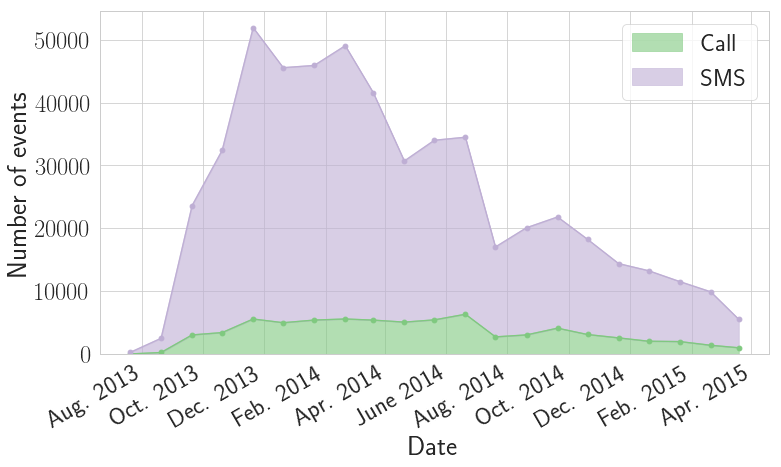

In [38]:
fig, ax = plt.subplots()
ddfc.plot.area(stacked=True, alpha=0.6, ax=ax)
fig.canvas.draw()

year, month = list(zip(*[el.get_text().split('-') for el in ax.get_xticklabels()]))
month = [monthNameLookup[int(mnt)] for mnt in month] 
xticks = [f"{month} {year}" for (year, month) in zip(year, month)]
ax.set_xticklabels(xticks); 

ddfc.Call.plot(marker='o', color=colorcycle[0], ax=ax)
ddfc.sum(axis=1).plot(marker='o', color=colorcycle[1], ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Number of events")
fig.canvas.draw() 
fig.savefig("figs/cleaned_call_and_sms_data_stacked_by_month.pdf")

Remove entries with users contacting themself

In [15]:
tmp = df.reset_index() 
tmp = tmp[(tmp.user != tmp.contactedUser)]
df = tmp.set_index(['user', 'comtype'], drop=False)
del tmp

In [16]:
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                                           
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

In [17]:
cleaned_number_of_rows = df.shape[0] 

In [18]:
original_number_of_rows

4922754

In [19]:
cleaned_number_of_rows

508811

This many percent data was discarded

In [20]:
(1 - cleaned_number_of_rows/original_number_of_rows)*100

89.66409859196702

In [21]:
n_call = df.xs('call', level=1).shape[0]
n_sms = df.xs('sms', level=1).shape[0]

n_sms / n_call

6.1591929197563005

# Finding cliques

NetworkX needs an undirected graph to find cliques, so that's what we'll construct.

We'll remove contacts with fewer than 3 communication events.

In [22]:
com = df.groupby('user').contactedUser.value_counts() 
com.head(12) 

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'user' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


user   contactedUser
u0001  u0493            121
       u0117             40
       u0783              6
       u0392              1
       u0791              1
u0002  u0796            108
       u0499             53
       u0287             30
       u0464             25
       u0592             23
       u0444             19
       u0211             18
Name: contactedUser, dtype: int64

In [23]:
com = com[com >= 3]

edges = com.index.tolist()

In [24]:
edges[:8]

[('u0001', 'u0493'),
 ('u0001', 'u0117'),
 ('u0001', 'u0783'),
 ('u0002', 'u0796'),
 ('u0002', 'u0499'),
 ('u0002', 'u0287'),
 ('u0002', 'u0464'),
 ('u0002', 'u0592')]

Construct the binary graph, find the cliques, and sort them by descending size, and remove cliques smaller than 3

In [25]:
g_dir = nx.DiGraph()
g_dir.add_edges_from(edges)

g_bin_rcp = g_dir.to_undirected(reciprocal=True)

In [26]:
cliques = pd.DataFrame([clq for clq in nx.algorithms.clique.find_cliques(g_bin_rcp) if len(clq) > 2])
cliques = cliques.iloc[np.argsort(cliques.count(axis=1))[::-1]]
cliques = cliques.reset_index(drop=True)
cliques.head() 

,0,1,2,3,4,5
0,u0645,u0683,u0618,u0446,u0993,u0388
1,u0324,u0287,u0128,u0758,u0951,None
2,u0489,u0128,u0758,u0491,u0154,None
3,u0489,u0128,u0758,u0491,u0287,None
4,u0705,u0758,u0128,u0393,u0724,None


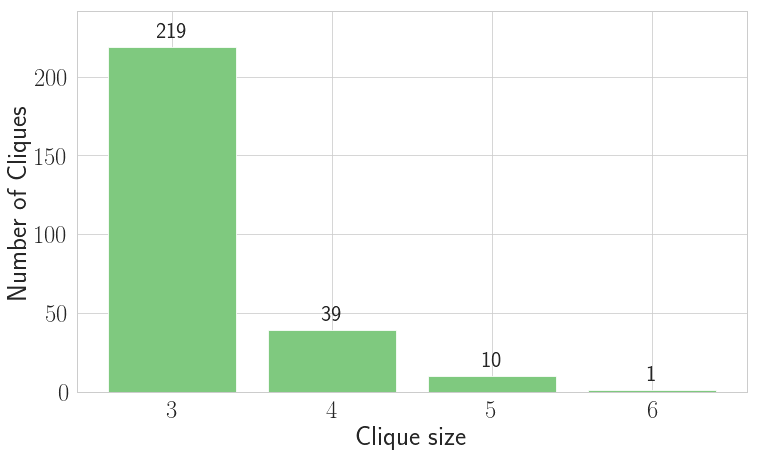

In [51]:
fig, ax = plt.subplots()
ax.bar([3,4,5,6], cliques.count(axis=1).value_counts())
ax.set_xlabel("Clique size")
ax.set_ylabel("Number of Cliques")
ax.set_xticks((3, 4, 5, 6))
plotting.looseAxesLimits(ax, (0, 0, 0, 0.05))
plotting.countsOnBarPlot(ax, fontsize=22)
fig.savefig("figs/clique_size_distribution_reciprocal.pdf")

In [27]:
g_bin = nx.Graph()
g_bin.add_edges_from(edges)
cliques = pd.DataFrame([clq for clq in nx.algorithms.clique.find_cliques(g_bin) if len(clq) > 2])
cliques = cliques.iloc[np.argsort(cliques.count(axis=1))[::-1]]
cliques = cliques.reset_index(drop=True)
cliques.head() 

,0,1,2,3,4,5,6
0,u0645,u0683,u0618,u0676,u0446,u0993,u0388
1,u0489,u0128,u0491,u0758,u0813,u0154,None
2,u0324,u0287,u0128,u0758,u0491,u0813,None
3,u0324,u0073,u0211,u0607,u0226,u0930,None
4,u0489,u0128,u0491,u0758,u0813,u0287,None


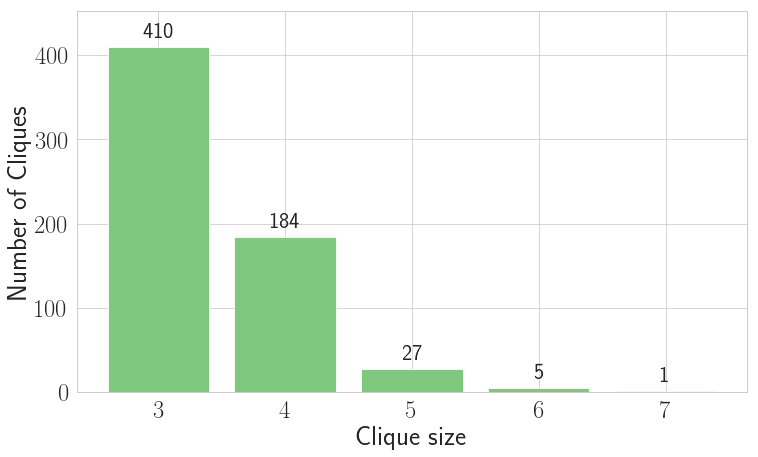

In [53]:
fig, ax = plt.subplots()
ax.bar([3,4,5,6,7], cliques.count(axis=1).value_counts())
ax.set_xlabel("Clique size")
ax.set_ylabel("Number of Cliques")
ax.set_xticks((3, 4, 5, 6, 7))
plotting.looseAxesLimits(ax, (0, 0, 0, 0.05))
plotting.countsOnBarPlot(ax, fontsize=22)
fig.savefig("figs/clique_size_distribution.pdf")

# Construct timebinned adjacency matrices for users, and do the stacking-PCA


### Determine start time offset for the binning 

Find the first occuring communication...

In [93]:
t0 = df.timestamp.min() 
t0

Timestamp('2013-07-02 19:07:49')

…and choose the corresponding day...

In [94]:
t0d = pd.Timestamp(t0.date())
t0d

Timestamp('2013-07-02 00:00:00')

Since the timeint is in seconds, but Pandas keeps it's records in nanoseconds, the integer representation of the date needs to be divided by 1e9.

To check that this is indeed true, compare the values of the integer casted `t0` to the timeint for the corresponding row:

In [95]:
np.int64(t0.value // 1e9) == df.loc[df.timestamp.idxmin()].timeint.values[0]

True

Since it was true, use the following for the bin time start

In [96]:
t0d = np.int64(t0d.value // 1e9)
t0 = np.int64(t0.value // 1e9) 
t0d

1372723200

Binning is simply performed by integer division with a suiting bin width.
I choose 8 hours:

In [97]:
bw8h = 60**2*8
df['tbin'] = (df.timeint - t0d) // bw8h
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser  tbin
user  comtype                                                                                                 
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493   624
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493   640
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117   661
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493   661
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117   766

Does it make sense to start the bins a midnight?

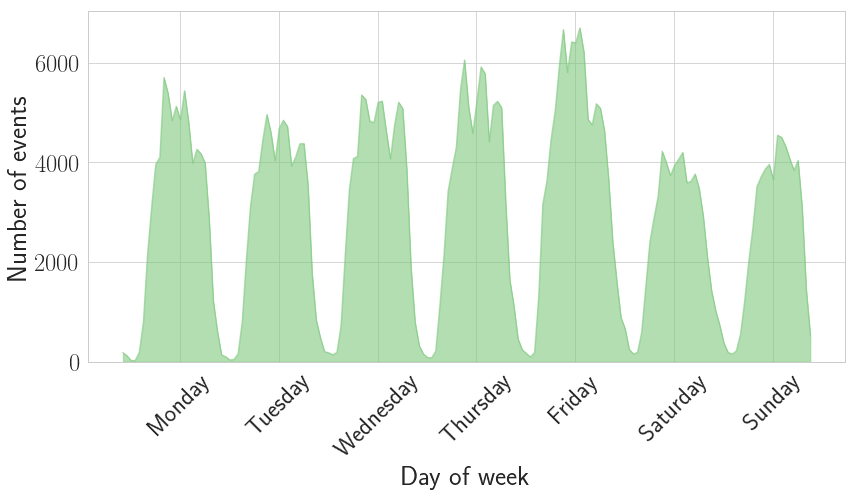

In [98]:
grp = df.groupby([df.timestamp.dt.dayofweek, df.timestamp.dt.hour]).timeint.count()  

grp.index = pd.TimedeltaIndex(freq='H', start=0, periods=24*7) 

fig, ax = plt.subplots()
grp.plot.area(alpha=0.6, ax=ax) 
ax.set_xticks( pd.TimedeltaIndex(freq='D', periods=7, start=0).values.astype(float)+5e13 )
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_ylabel("Number of events")
ax.set_xlabel("Day of week")
ax.xaxis.set_tick_params(rotation=45) 
fig.tight_layout()
fig.savefig("figs/weekly_activity_by_hour.pdf")

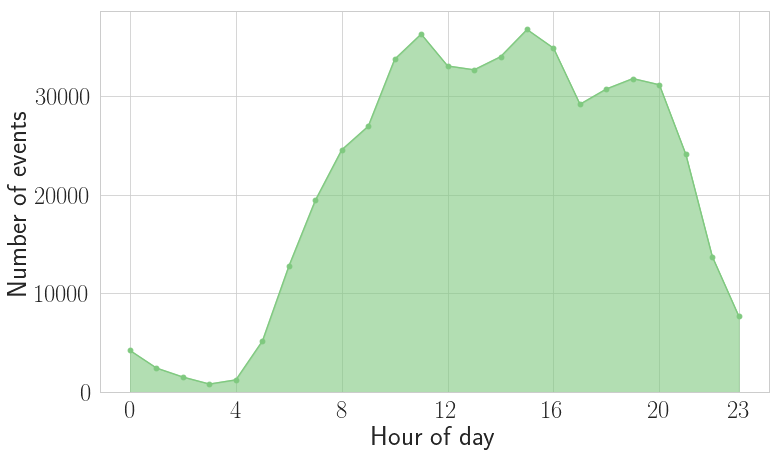

In [99]:
grp = df.groupby(df.timestamp.dt.hour).timeint.count() 
fig, ax = plt.subplots()
grp.plot.area(alpha=0.6, ax=ax) 
grp.plot(kind='line', color=colorcycle[0], style='-o', ax=ax) 
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of events")
ax.set_xticks([0, 4, 8, 12, 16, 20, 23]) 
fig.savefig("figs/dayly_events_by_hour.pdf") 

Test it with a 5-clique

In [112]:
# tryout_clique = cliques[(cliques.count(axis=1) == 5)].iloc[8].dropna().tolist()
tryout_clique = ['u0739', 'u0122', 'u0392', 'u0264', 'u0117']
print(*tryout_clique, sep='\t')

fitFunctionKwargs={'performStandardization': False, 'performMeanTranslation': True}
pca = userActivityFunctions.community2Pca(df, tryout_clique, 'tbin', nx.Graph, fitFunctionKwargs=fitFunctionKwargs)

print(f'pca.components_.shape : {pca.components_.shape}', sep='\n', end='\n\n')
print(f'pca.explained_variance_ratio_ : {pca.explained_variance_ratio_}', sep='\n', end='\n\n') 
print(f'np.cumsum(pca.explained_variance_ratio_) : {np.cumsum(pca.explained_variance_ratio_)}', sep='\n', end='\n\n')

n_to_plot = (np.cumsum(pca.explained_variance_ratio_) < 0.95).sum() + 1
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below") 

u0739	u0122	u0392	u0264	u0117
pca.components_.shape : (10, 240)

pca.explained_variance_ratio_ : [6.60655300e-01 2.36336066e-01 3.92128850e-02 2.14718994e-02 1.54975461e-02 1.21486975e-02 7.00350468e-03 6.32174690e-03 1.35235358e-03
 1.58240644e-32]

np.cumsum(pca.explained_variance_ratio_) : [0.6606553  0.89699137 0.93620425 0.95767615 0.9731737  0.98532239 0.9923259  0.99864765 1.         1.        ]

The first 4 componentes explain 95 % of the variance — plotted below


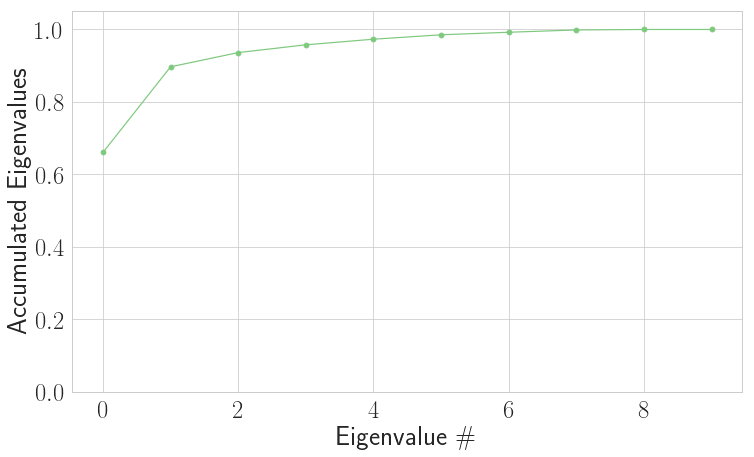

In [103]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_ylim([0, 1.05])
ax.set_xlabel("Eigenvalue \\#")
ax.set_ylabel("Accumulated Eigenvalues")
fig.savefig(f"figs/pca_{len(pca.community_)}_clique_undirected_eigenvalues_cumsum.pdf") 

Define a custom weight-function for the graph edges plotting routine.
Very bold edges are required, because the figures will be rather small in the report.

In [104]:
n_to_plot = (np.cumsum(pca.explained_variance_ratio_) < 0.95).sum() + 1
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below") 

The first 4 componentes explain 95 % of the variance — plotted below


In [105]:
def get_vertex_size(g):
    vertex_size = np.abs(np.asarray(nx.adjacency_matrix(g).todense()))
    vertex_size = (1 + vertex_size.sum(axis=0))**2 + (1 + vertex_size.sum(axis=1))**2
    vertex_size /= vertex_size.max() 
    vertex_size *= 50
    return vertex_size

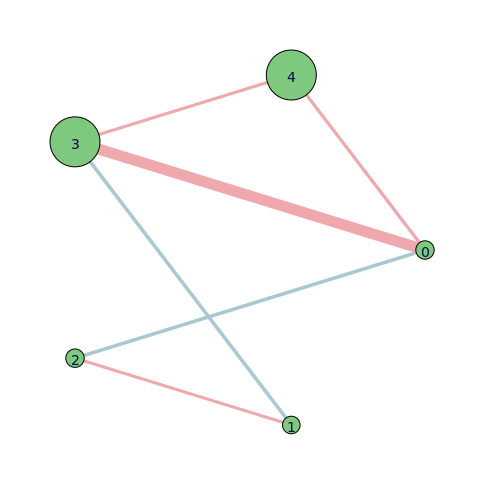

0.6606553004099562


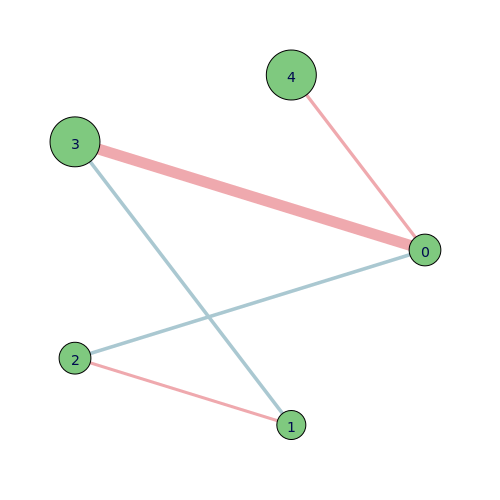

0.23633606646363542


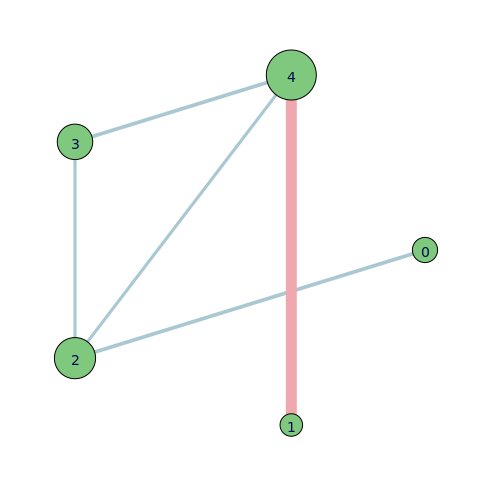

0.03921288497725214


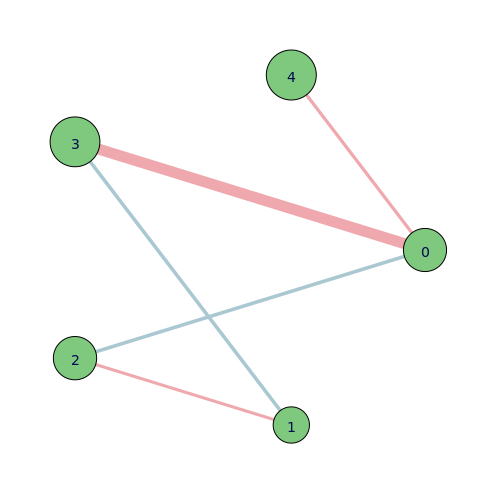

0.021471899353804155


In [113]:
weightFunc = lambda g: [3 + 8*wt/max(g.es['weight']) for wt in g.es['weight']] 

layout = None
keepsies_dct = dict()
keepsies_idx = (1, 3) 
undirected = pca.explained_variance_ratio_[:n_to_plot] 

for i in range(n_to_plot):
    am = graph.upperTril2adjMat(pca.components_[:, i]) 
    if i in keepsies_idx:
        keepsies_dct[f"{i}_before_pruning"] = am.copy()
    am[np.abs(am) < 1e-5] = 0
    if i in keepsies_idx:
        keepsies_dct[f"{i}_after_pruning"] = am.copy()
    g_pca = nx.from_numpy_matrix(am)
    if layout is None:
        layout = graph.nx2ig(g_pca).layout('circle')
    filename = f"figs/pca_graph_{len(pca.community_)}_undirected_clique_component_{i+1}_of_{n_to_plot}.pdf"
    vertex_size = get_vertex_size(g_pca)
    disp(plotting.igdraw(g_pca, filename=filename, bbox=(500, 500), layout=layout,
                         weightFunc=weightFunc, allowNegativeWeights=True, vertex_size=vertex_size))
    print(pca.explained_variance_ratio_[i])

Inspect the adjacency matrices for two very similar looking graphs.

In [114]:
for k, v in keepsies_dct.items():
    print(k)
    print(v, end='\n\n')

1_before_pruning
[[ 0.00000000e+00 -3.36623378e-03  4.61325244e-02  1.61961141e-03  3.73716437e-04]
 [-3.36623378e-03  0.00000000e+00  6.63061172e-04  1.68889140e-04 -1.62561858e-03]
 [ 4.61325244e-02  6.63061172e-04  0.00000000e+00 -2.50123871e-03 -3.38481647e-03]
 [ 1.61961141e-03  1.68889140e-04 -2.50123871e-03  0.00000000e+00 -3.14927178e-01]
 [ 3.73716437e-04 -1.62561858e-03 -3.38481647e-03 -3.14927178e-01  0.00000000e+00]]

1_after_pruning
[[ 0.00000000e+00 -3.36623378e-03  4.61325244e-02  1.61961141e-03  3.73716437e-04]
 [-3.36623378e-03  0.00000000e+00  6.63061172e-04  1.68889140e-04 -1.62561858e-03]
 [ 4.61325244e-02  6.63061172e-04  0.00000000e+00 -2.50123871e-03 -3.38481647e-03]
 [ 1.61961141e-03  1.68889140e-04 -2.50123871e-03  0.00000000e+00 -3.14927178e-01]
 [ 3.73716437e-04 -1.62561858e-03 -3.38481647e-03 -3.14927178e-01  0.00000000e+00]]

3_before_pruning
[[ 0.         -0.00673247  0.09226505  0.00323922  0.00074743]
 [-0.00673247  0.          0.00132612  0.00033778 -0.

Try with a directed graph

In [115]:
pca = userActivityFunctions.community2Pca(df, tryout_clique, 'tbin', nx.DiGraph, excludeDiagonal=True,
                                          fitFunctionKwargs=fitFunctionKwargs)
print(f'pca.components_.shape : {pca.components_.shape}', sep='\n', end='\n\n')
print(f'pca.explained_variance_ratio_ : {pca.explained_variance_ratio_}', sep='\n', end='\n\n')  

pca.components_.shape : (20, 240)

pca.explained_variance_ratio_ : [7.74797761e-01 1.32693019e-01 2.30344549e-02 2.02392726e-02 1.33626941e-02 1.02071194e-02 8.45858256e-03 6.18790581e-03 3.98894169e-03
 3.75642676e-03 1.57048535e-03 9.97548422e-04 4.57184534e-04 1.49821098e-04 7.84891730e-05 2.02930588e-05 2.35276537e-32 1.11161203e-34
 3.41736682e-35 1.40379460e-38]



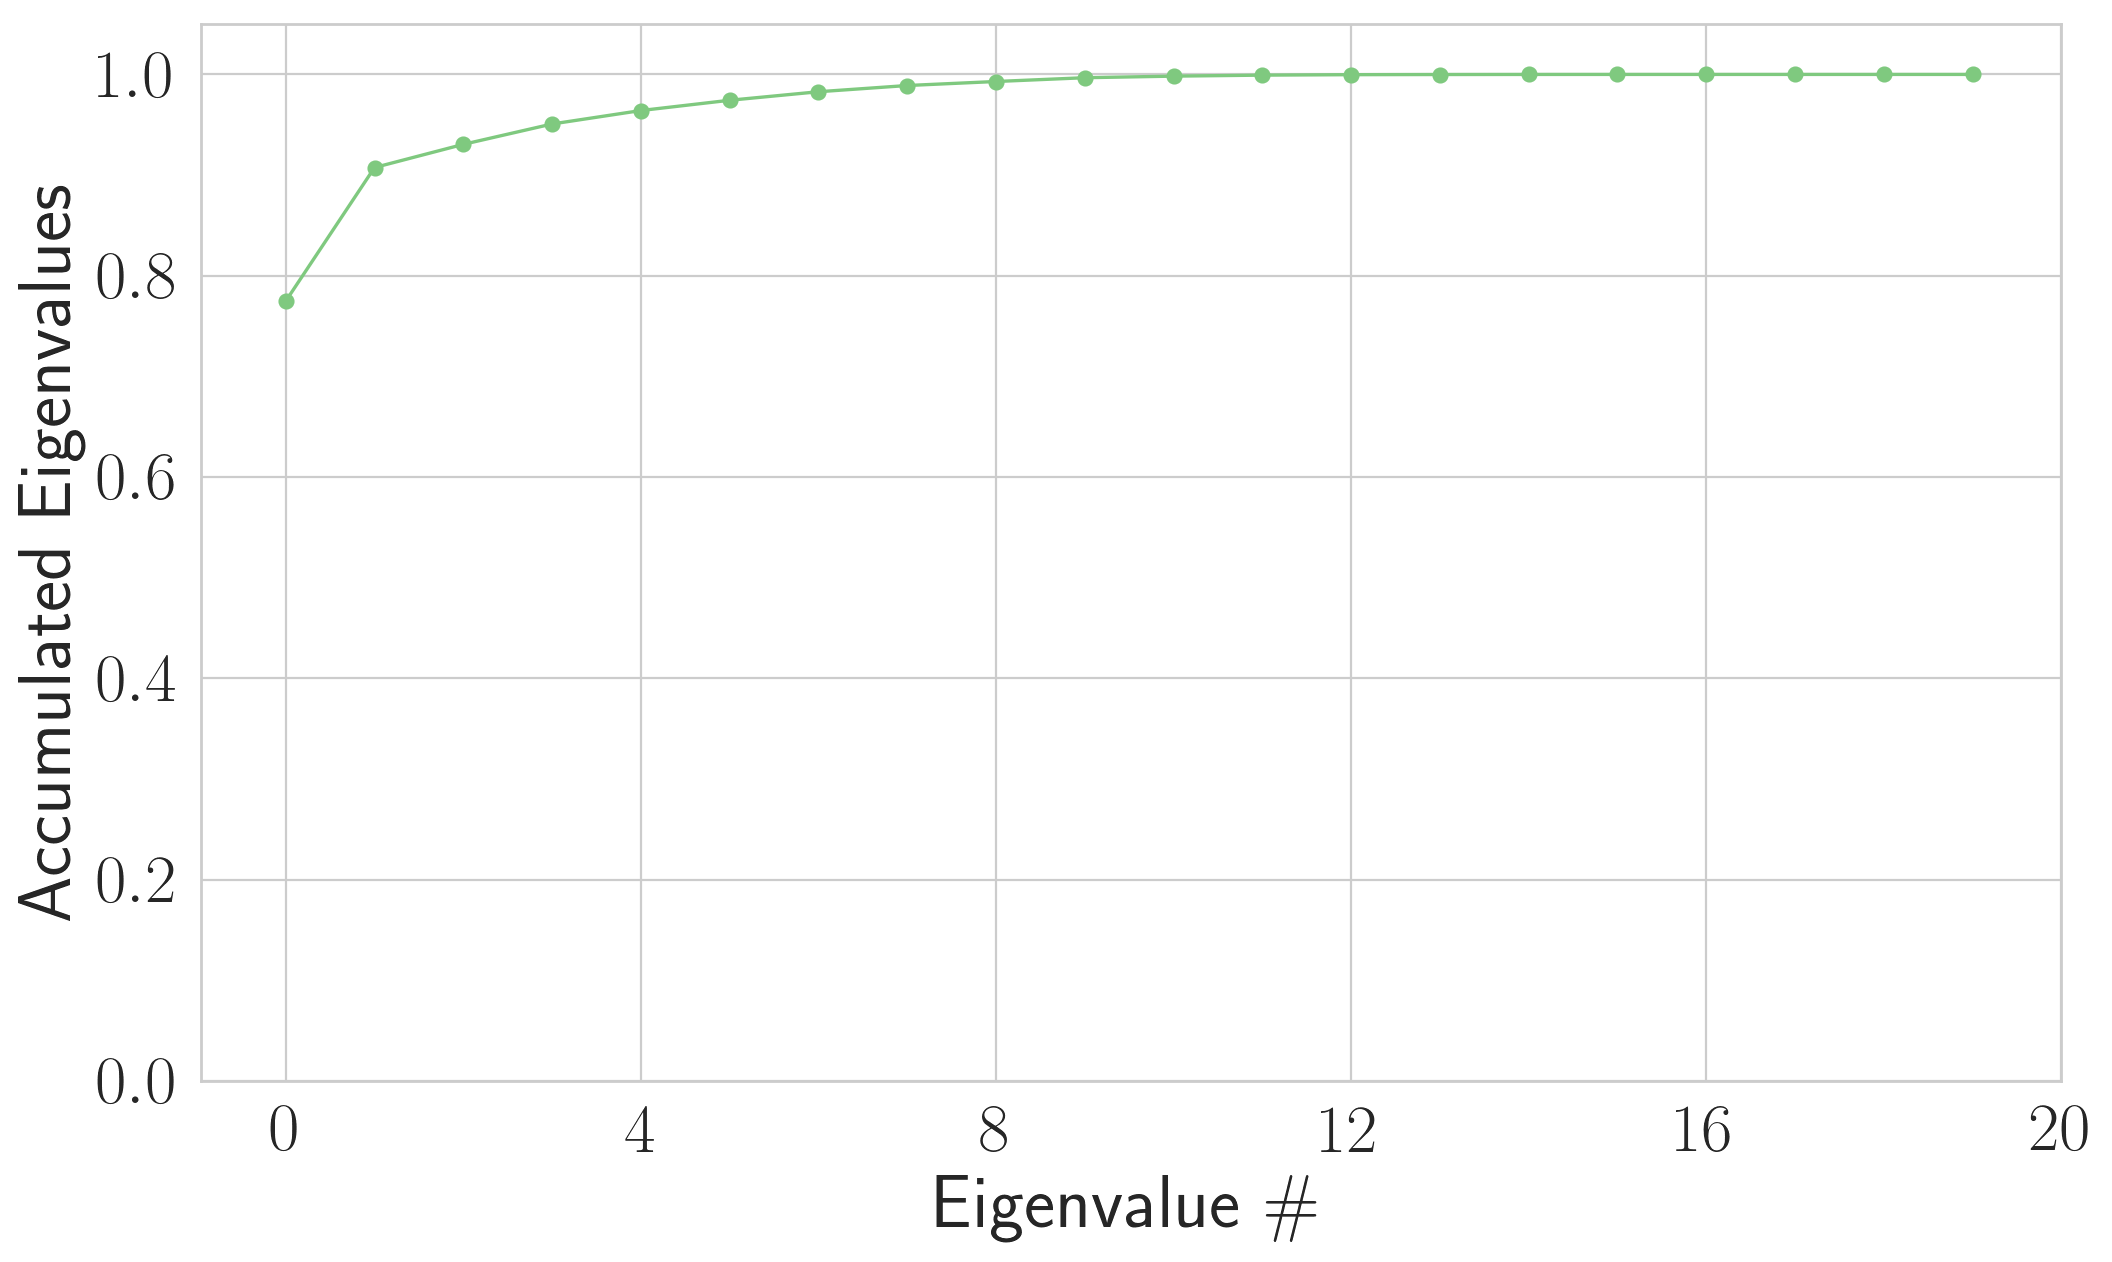

In [116]:
fig, ax = plt.subplots(dpi=200)
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_ylim([0, 1.05])
ax.set_xticks(np.arange(0, 21, 4))
ax.set_xlabel("Eigenvalue \\#")
ax.set_ylabel("Accumulated Eigenvalues")
fig.savefig(f"figs/pca_{len(pca.community_)}_clique_directed_eigenvalues_cumsum.pdf") 

The first 4 componentes explain 95 % of the variance — plotted below


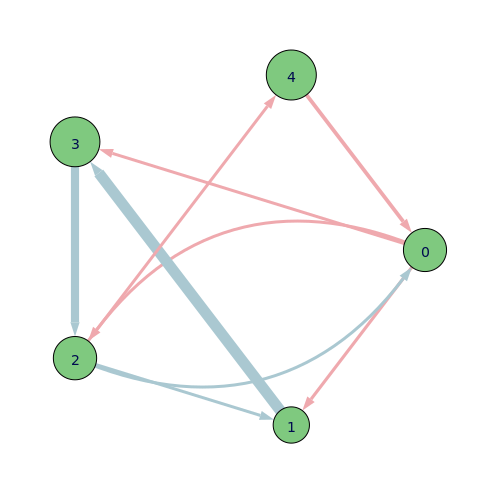

0.7747977612893251


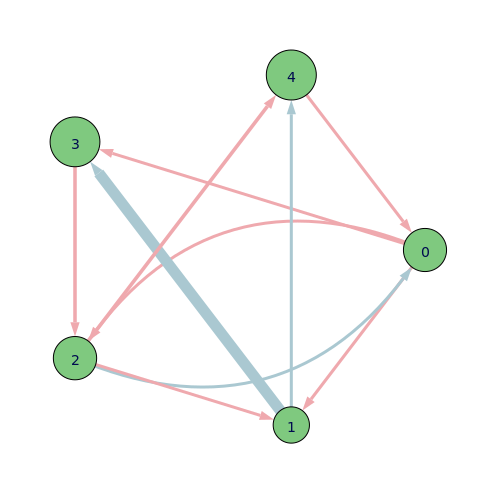

0.13269301931313318


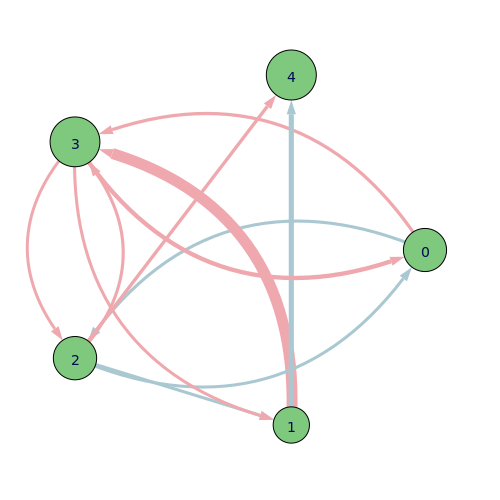

0.02303445491633406


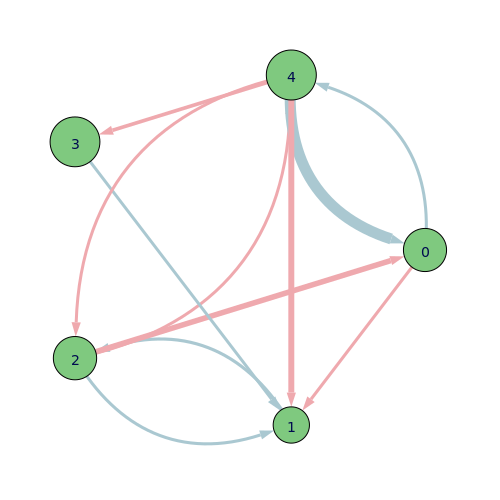

0.020239272585884833


In [117]:
n_to_plot = (np.cumsum(pca.explained_variance_ratio_) <= 0.95).sum() + 1

weightFunc = lambda g: [3 + 8*wt/max(g.es['weight']) for wt in g.es['weight']] 

directed = pca.explained_variance_ratio_[:n_to_plot]
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below") 
layout = None
for i in range(n_to_plot):
    am = graph.vec2squareMat(pca.components_[:, i], addDiagonal=True) 
    # amorg = am.copy() 
    # am += np.abs(am.min())
    # am[np.eye(am.shape[0], dtype=bool)] = 0  # make the diagonal 0 again
    # am[am < am.max()/100] = 0
    am[np.abs(am) < 1e-5] = 0
    g_pca = nx.from_numpy_matrix(am, create_using=nx.DiGraph())
    if layout is None:
        layout = graph.nx2ig(g_pca).layout('circle') 
    filename = f"figs/pca_graph_{len(pca.community_)}_directed_clique_component_{i+1}_of_{n_to_plot}.pdf"
    disp(plotting.igdraw(g_pca, filename=filename, bbox=(500, 500), layout=layout,
                         weightFunc=weightFunc, allowNegativeWeights=True, vertex_size=vertex_size))

    print(pca.explained_variance_ratio_[i]) 

Print the subfigure labels in LaTeX format

In [145]:
undirected_cs = np.cumsum(undirected) 
directed_cs = np.cumsum(directed)

# $\lambda_1 = 0.661$ \\ $\sum_{i=1}^1 \lambda_i = 0.661$.

print("Undirected\t\tSummed")
for i, (n, s) in enumerate(zip(undirected, undirected_cs), 1):
    print("$\lambda_{} = {:.3}$ \\\\ $\sum_{{i=1}}^{} \lambda_i = {:.3}$.".format(i, n, i, s)) 

print("\nDirected\t\tSummed")
for i, (n, s) in enumerate(zip(directed, directed_cs), 1):
    print("$\lambda_{} = {:.3}$ \\\\ $\sum_{{i=1}}^{} \lambda_i = {:.3}$.".format(i, n, i, s)) 
 

Undirected		Summed
$\lambda_1 = 0.661$ \\ $\sum_{i=1}^1 \lambda_i = 0.661$.
$\lambda_2 = 0.236$ \\ $\sum_{i=1}^2 \lambda_i = 0.897$.
$\lambda_3 = 0.0392$ \\ $\sum_{i=1}^3 \lambda_i = 0.936$.
$\lambda_4 = 0.0215$ \\ $\sum_{i=1}^4 \lambda_i = 0.958$.

Directed		Summed
$\lambda_1 = 0.775$ \\ $\sum_{i=1}^1 \lambda_i = 0.775$.
$\lambda_2 = 0.133$ \\ $\sum_{i=1}^2 \lambda_i = 0.907$.
$\lambda_3 = 0.023$ \\ $\sum_{i=1}^3 \lambda_i = 0.931$.
$\lambda_4 = 0.0202$ \\ $\sum_{i=1}^4 \lambda_i = 0.951$.


# Do it for _all_ cliques

Args for multiprocessing.

Since the arguments symmetric = True/False are monkay-patched onto the PCA object, we can easily identify what we whether a Graph or DiGraph was used to create the adjacency matrices in use.

In [46]:
try:
    del args_lst
except NameError:
    pass

args_lst = list()
for ri, row in cliques.iterrows():
    clq = row.dropna().tolist()
    
    args = (
    df,           #  userDf
    clq,          #  community
    'tbin',       #  binColumn
    nx.DiGraph,   #  graphtype
    False,        #  excludeDiagonal
    misc.pcaFit,  #  fitFunction
    fitFunctionKwargs, #  fitFunctionKwargs
    -ri           #  printProgress
    )
    args_lst.append(args)

    args = (
    df,           #  userDf
    clq,          #  community
    'tbin',       #  binColumn
    nx.Graph,     #  graphtype
    False,        #  excludeDiagonal
    misc.pcaFit,  #  fitFunction
    fitFunctionKwargs, #  fitFunctionKwargs
    ri            #  printProgress
    )
    args_lst.append(args) 

In [47]:
len(args_lst)

1254

In [48]:
pca = userActivityFunctions.community2Pca(*args_lst[-1])
pca

Clique number 626 processed, members: ('u0601', 'u0690', 'u0378')


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Seems to work when evaluated on the local Python process

In [49]:
if COMPUTE_PCA:
    with multiprocessing.Pool(processes=30) as pool:
        pca_result_pool = pool.starmap(userActivityFunctions.community2Pca, args_lst)

Count datatypes: All seem to be PCA, which meant that none of the jobs raised a `ValueError`, in which case the result should be `np.NaN`, which have type `float`.

In [50]:
if COMPUTE_PCA:
    Counter(type(el) for el in pca_result_pool)

Get communities in the order thay're saved in the pool-result

In [51]:
if COMPUTE_PCA:
    communities = [pca.community_ for pca in pca_result_pool]

Save the results to a DataFrame

In [93]:
pcadf = pcadf[pcadf.symmetric == False]

In [98]:
pcadf['n95'] = pcadf.pca.map(lambda x: (np.cumsum(x.explained_variance_ratio_) <= 0.95).sum())  

In [104]:
pcadf[(pcadf.n95 == 4) & (~pcadf.symmetric) & (pcadf.n_clique == 5)].clique.map(set) == {'u0739', 'u0122', 'u0392', 'u0264', 'u0117'}

60     True
54    False
22    False
32    False
30    False
Name: clique, dtype: bool

In [96]:
if COMPUTE_PCA:
    pcadf = pd.DataFrame([pca_result_pool, communities], index="pca clique".split()).T
    pcadf = pcadf.iloc[np.argsort(pcadf.clique.map(len))[::-1]]
    pcadf['symmetric'] = pcadf.pca.map(lambda x: x.symmetric_) 
    pcadf['n_clique'] = pcadf.clique.map(len)
    pcadf.head() 
else:
    try:  # is pcadf alreaddy defined?
        pcadf.dtypes()
    except NameError:  # it wasn't, so load it if the file exists
        if os.path.isfile('../../allan_data/pca_cliques_second_take_results_no_standardization.hdfstore'):
            with pd.HDFStore('../../allan_data/pca_cliques_second_take_results_no_standardization.hdfstore') as store:
                pcadf = store['pcadf']
    

TypeError: 'Series' object is not callable

And save the DataFrame as a Pandas HDFStore

In [113]:
pca = pcadf.loc[60, 'pca']

In [114]:
pca = pcadf.loc[60, 'pca']

In [53]:
if COMPUTE_PCA:  # No need to save the PCA results to a file, unless it was re-computed.
    with pd.HDFStore('../../allan_data/pca_cliques_second_take_results_no_standardization.hdfstore') as store:
        store['pcadf'] = pcadf

# Apply clustering algorithms

* Perform some clustering with different algorithms
* Project to 2D using t-sne
    - Colorize cluster with results from high dimmensional clustering algorithms
    - Try different valus for t-sne perplexity, and describe whet they do
* Consider trying UMAP

### Collect the vectors for the graphs of differet clique sizes

Split collections based on directed or undirected graphs, and on clique size

In [137]:
pcadf.n_clique.value_counts() // 2  # divided by 2 because we separate directed and undirected graphs

3    410
4    184
5     27
6      5
7      1
Name: n_clique, dtype: int64

In [138]:
mask = pcadf.symmetric & (pcadf.n_clique == 5)

In [139]:
lst_components = list()
lst_index = list()
for ipca in pcadf[mask].pca:
    n_components = (np.cumsum(ipca.explained_variance_ratio_) <= 0.95).sum()
    to_append = ipca.components_[:, :n_components]
    lst_components.append(to_append)
    lst_index.append(np.arange(n_components)) 

In [140]:
pca.components_.shape

(10, 240)

In [141]:
clique_mode = np.concatenate(lst_components, axis=1).T
clique_index = np.concatenate(lst_index)

### Plot using t-SNE

Apple t-SNE and plot the vectors

In [167]:
from sklearn import manifold
from sklearn import cluster
from hdbscan import HDBSCAN
from umap import UMAP 

In [143]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode)

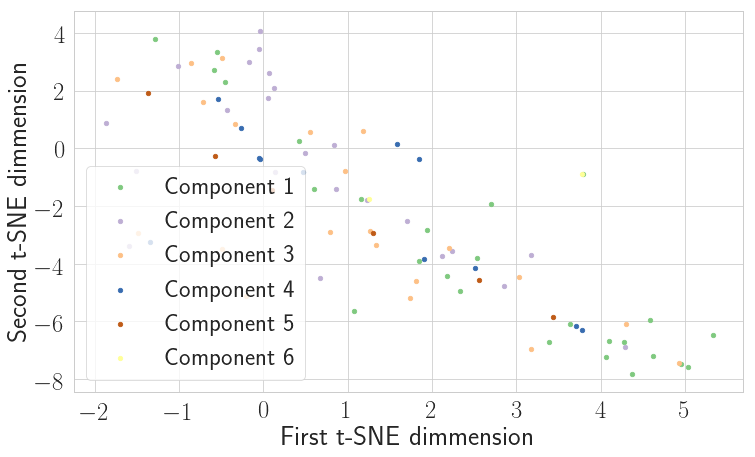

In [144]:
fig, ax = plt.subplots()
for i in pd.unique(clique_index):
    ax.scatter(*data_tsne[clique_index == i].T, s=20, color=colorcycle[i], label=f"Component {i+1}") 
ax.legend(loc='lower left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")

In [145]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit_transform(clique_mode) 

Try clustering the points with different algorithms

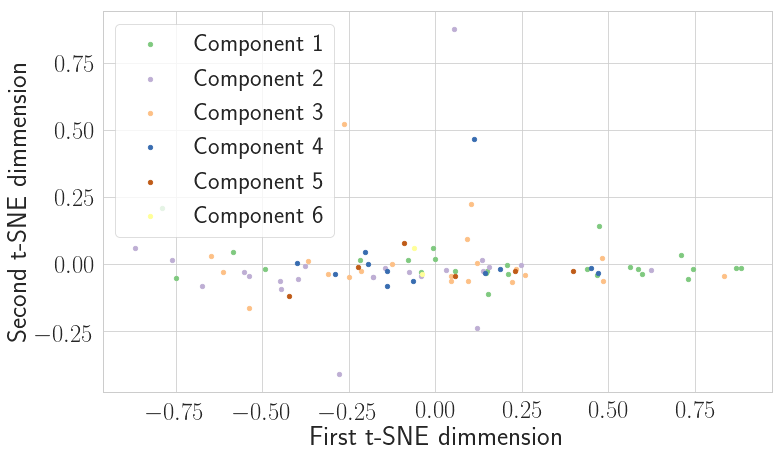

In [146]:
fig, ax = plt.subplots()
for i in pd.unique(clique_index):
    ax.scatter(*data_pca[clique_index == i].T, s=20, color=colorcycle[i], label=f"Component {i+1}") 
ax.legend(loc='upper left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/pca_componnts_colored_5_clique_directed.pdf")

In [147]:
pd.value_counts(clique_index)

0    26
1    23
2    21
3    12
4     6
5     2
dtype: int64

In [148]:
clstData = misc.standardizeData(clique_mode) 

#### KMeans

In [149]:
kmeans = cluster.KMeans(max_iter=1000, n_jobs=16, n_clusters=6) 
kmeans.fit(clstData)
clst = kmeans.fit_predict(clstData)
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([60,  3,  1,  3, 20,  3]))

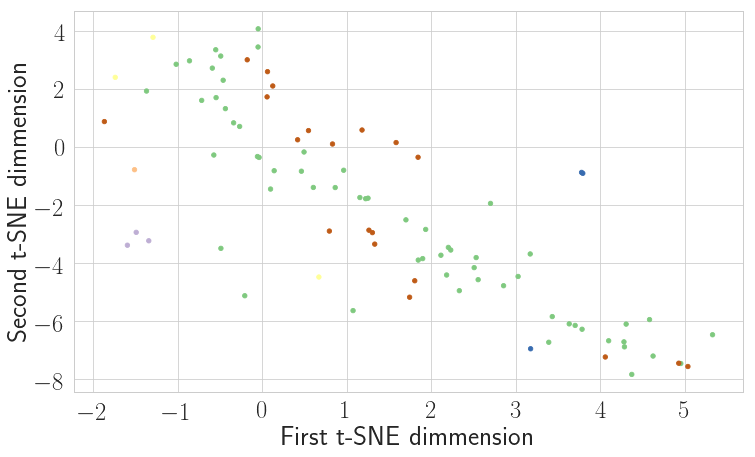

In [150]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_kmeans_clusters_perp_30_colored_5_clique_directed.pdf") 

#### HDBScan

In [151]:
hdbscan = cluster.DBSCAN(n_jobs=16, min_samples=3)
hdbscan.fit(clstData)
clst = hdbscan.fit_predict(clstData)

pd.value_counts(clst)

-1    76
 0    10
 1     4
dtype: int64

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


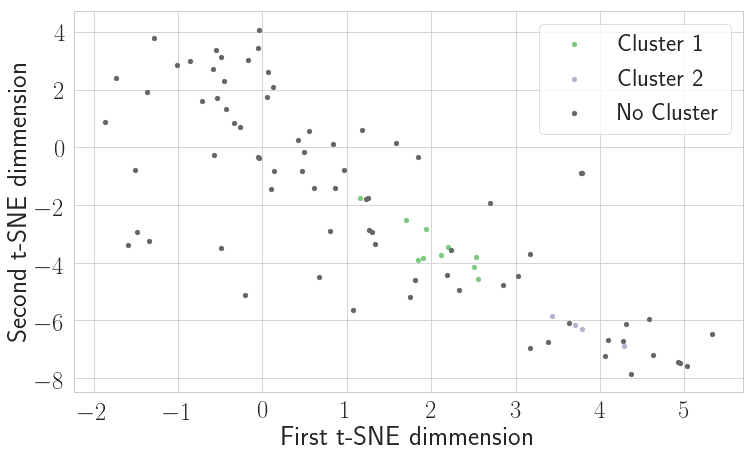

In [152]:
fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper right') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_hdbscan_perp_30_colored_5_clique_directed.pdf")

##### T-SNE with perplexity 5

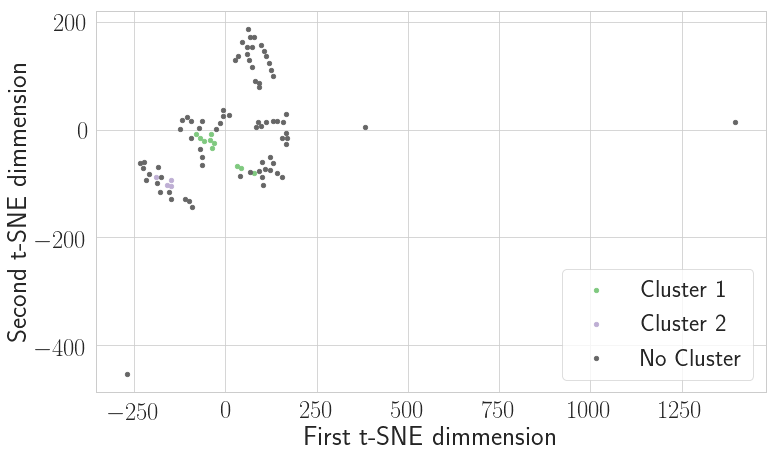

In [153]:
np.random.seed(1234567890) 
tsne = manifold.TSNE(perplexity=5)
data_tsne = tsne.fit_transform(clique_mode)

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='lower right') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_hdbscan_perp_5_seeded_colored_5_clique_directed.pdf")

##### T-SNE with perplexity 30

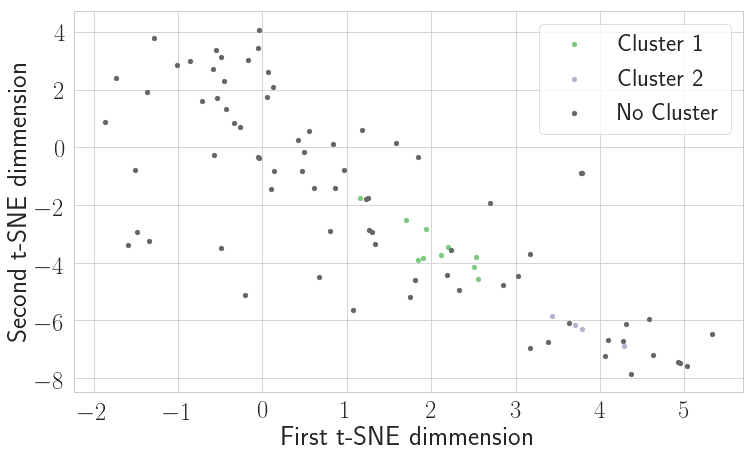

In [154]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode)

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper right')
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_hdbscan_perp_30_seeded_colored_5_clique_directed.pdf")

##### T-SNE with perplexity 55

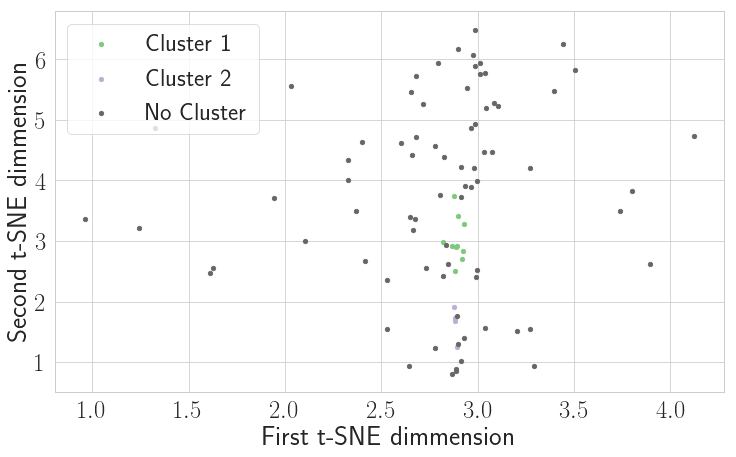

In [155]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=55)
data_tsne = tsne.fit_transform(clique_mode) 

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_hdbscan_perp_55_seeded_colored_5_clique_directed.pdf")

##### T-SNE with exact calculation instead of the Barnes Hut approximaion, perplexity 30

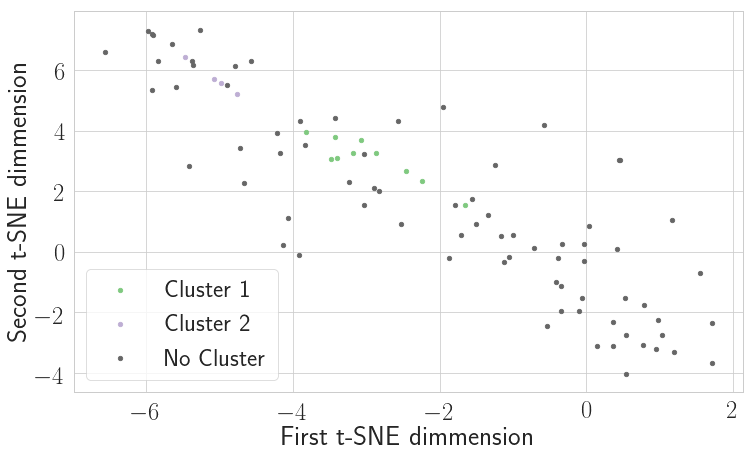

In [156]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30, method='exact')
data_tsne = tsne.fit_transform(clique_mode) 

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='lower left') 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_exact_hdbscan_perp_30_seeded_colored_5_clique_directed.pdf")

#### Spectral clustering

In [157]:
sp_clst = cluster.SpectralClustering(n_jobs=6, n_clusters=6)
clst = sp_clst.fit_predict(clstData)

pd.value_counts(clst)

1    47
3    15
0    12
2    10
4     4
5     2
dtype: int64

In [158]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode) 

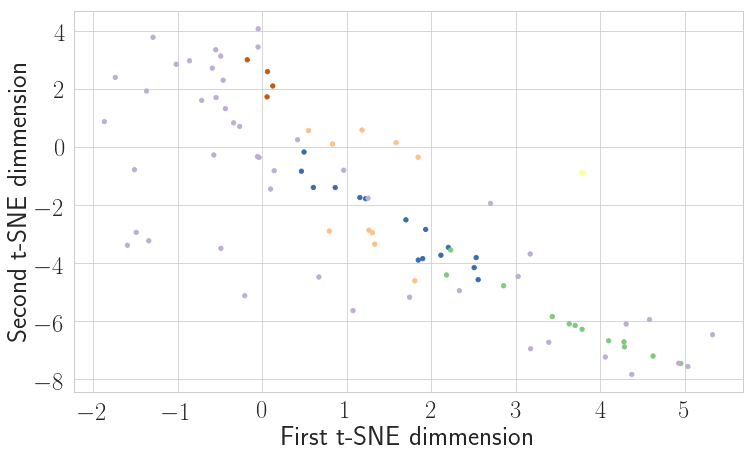

In [159]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}")
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension") 
fig.savefig(f"figs/tsne_spectralClustering_perp_30_seeded_colored_5_clique_directed.pdf")

### AgglomerativeClustering

In [160]:
agg_clst = cluster.AgglomerativeClustering(n_clusters=6)
clst = agg_clst.fit_predict(clstData)

pd.value_counts(clst)

4    75
1     6
0     4
2     3
5     1
3     1
dtype: int64

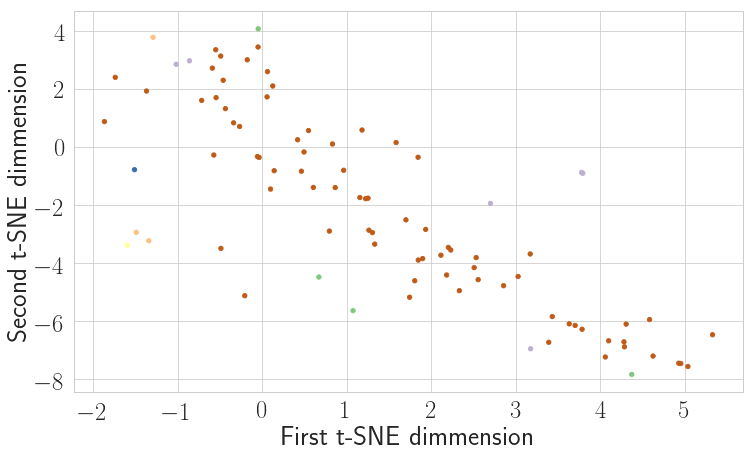

In [161]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_agglomerativeClustering_perp_30_seeded_colored_5_clique_directed.pdf")

### Affinity propagation

In [162]:
aff_clst = cluster.AffinityPropagation()
clst = agg_clst.fit_predict(clstData)

pd.value_counts(clst)

4    75
1     6
0     4
2     3
5     1
3     1
dtype: int64

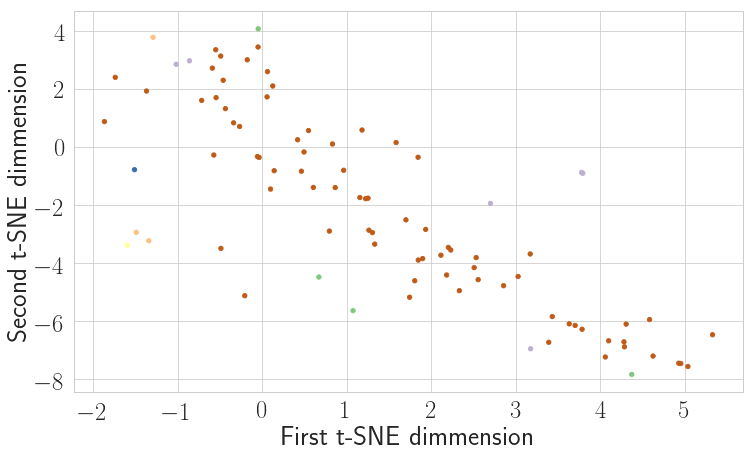

In [163]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First t-SNE dimmension")
ax.set_ylabel("Second t-SNE dimmension")
fig.savefig(f"figs/tsne_affinityPropagation_perp_30_seeded_colored_5_clique_directed.pdf")

## UMAP

In [ ]:
hdbscan.

In [165]:
hdbscan = cluster.DBSCAN(n_jobs=16, min_samples=3)
hdbscan.fit(clstData)
clst = hdbscan.fit_predict(clstData)

pd.value_counts(clst) 

-1    76
 0    10
 1     4
dtype: int64

Text(0,0.5,'Second UMAP dimmension')

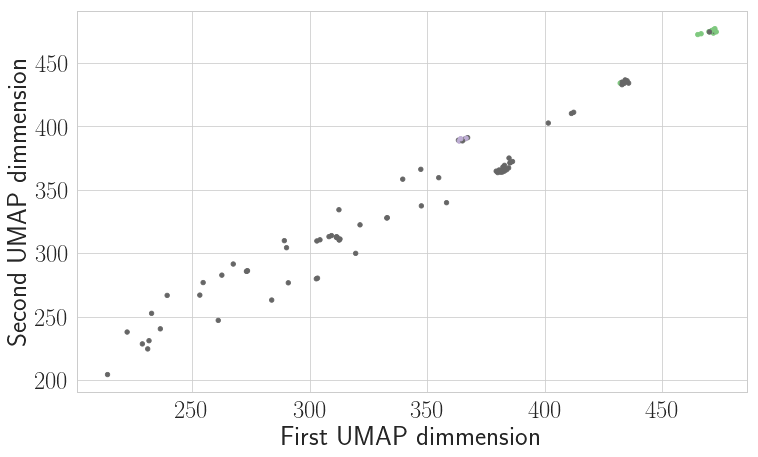

In [166]:
np.random.seed(1234567890) 
umap = UMAP(repulsion_strength=10) 
data_umap = umap.fit_transform(clique_mode) 

fig, ax = plt.subplots()
ax.scatter(*data_umap.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First UMAP dimmension")
ax.set_ylabel("Second UMAP dimmension")



Thoughts…

* UMAP should be included, with some references, but no in-depth explanation
* Clustering on UMAP reduced dataset, and talk about curse of dimmensionality
* Quote Ronald Coase, How to Lie with Statistics: "if you torture the data long enough, it will confess to anything"

In [176]:
np.random.seed(1234567890) 
umap_n6 = UMAP(repulsion_strength=10, n_components=2) 
clstData_n6 = umap_n6.fit_transform(clique_mode) 

In [182]:
hdbscan_n6 = HDBSCAN(core_dist_n_jobs=4, min_cluster_size=3)
hdbscan.fit(data_umap)
clst = hdbscan.fit_predict(data_umap)

pd.value_counts(clst) 

-1    84
 1     3
 0     3
dtype: int64

Text(0,0.5,'Second UMAP dimmension')

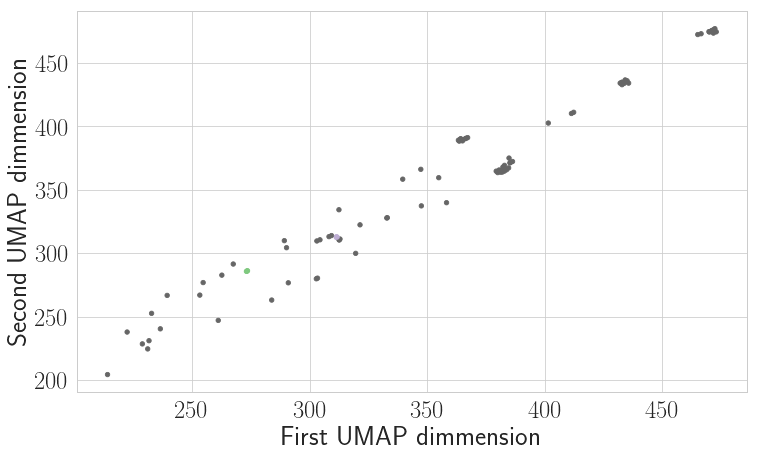

In [183]:
fig, ax = plt.subplots()
ax.scatter(*data_umap.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
ax.set_xlabel("First UMAP dimmension")
ax.set_ylabel("Second UMAP dimmension") 